In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import sys
import json
import argparse
from collections import Counter
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets, models
from torch.utils.data import DataLoader, Dataset,random_split,SubsetRandomSampler, WeightedRandomSampler
from tqdm import tqdm
import numpy as np


In [ ]:
from matplotlib import pyplot as plt

In [ ]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe):
        self.dataframe = dataframe

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        x_cont = torch.tensor(self.dataframe.iloc[idx]['X_cont'], dtype=torch.float32)

        other_cols = self.dataframe.drop(columns=['label', 'X_cont','Unit1'])
        x_other = torch.tensor(other_cols.iloc[idx].values, dtype=torch.float32)

        label = torch.tensor(self.dataframe.iloc[idx]['label'], dtype=torch.long)

        return x_cont, x_other, label

In [ ]:
class CNN(nn.Module):
    def __init__(self, dyn_channels=5, stat_channels=32):
        super(CNN, self).__init__()

        self.conv1 = nn.Conv1d(dyn_channels, 10, kernel_size=4, padding=1) # 8
        self.bn1 = nn.BatchNorm1d(10)
        self.conv2 = nn.Conv1d(10, 20, kernel_size=4, padding=1) # 6
        self.bn2 = nn.BatchNorm1d(20)
        self.conv3 = nn.Conv1d(20, 30, kernel_size=4, padding=1) # 4
        self.bn3 = nn.BatchNorm1d(30)
        #self.conv4 = nn.Conv1d(30, 25, kernel_size=3, padding=1) # 6
        #self.bn4 = nn.BatchNorm1d(25)

        self.fc1 = nn.Linear(30*7, 30)
        self.fc2 = nn.Linear(30, 10)
        self.flatten = nn.Flatten()
        self.fc_static1 = nn.Linear(stat_channels, 25)
        self.fc_static2 = nn.Linear(25, 30)
        self.fc_static3 = nn.Linear(30, 10)
        self.sigmoid = nn.Sigmoid()
        self.fc_final1 = nn.Linear(20, 10)
        self.fc_final2 = nn.Linear(10,2)


    def forward(self, x_dynamic, x_static):

        x_dynamic = x_dynamic.permute(0,2,1)
        #print(x_dynamic.shape)
        #print(x_static.shape)
        x = self.bn1(self.conv1(x_dynamic))
        x = torch.relu(x)
        x = self.bn2(self.conv2(x))
        x = torch.relu(x)
        x = self.bn3(self.conv3(x))
        x = torch.relu(x)
        #x = self.bn4(self.conv4(x))
        #x = torch.relu(x) #torch.Size([20, 25, 10])
        #print(x.shape)
        x = self.flatten(x)

        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))

        y = torch.relu(self.fc_static1(x_static))
        y = torch.relu(self.fc_static2(y))
        y = torch.relu(self.fc_static3(y))

        z = torch.cat((x, y), dim=1)
        z = self.fc_final2((torch.relu(self.fc_final1(z))))

        return z


In [ ]:
trainval_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/train.pkl').reset_index(drop=True)

class_0 = trainval_df[trainval_df['label'] == 0]
class_1 = trainval_df[trainval_df['label'] == 1]
n_samples = len(class_1)
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
train_df = df_balanced.reset_index(drop=True)

N = len(train_df)
train_df = train_df.sample(frac=1).reset_index(drop=True)
val = train_df[:int(N*0.2)]
train_df = train_df[int(N*0.2):]
train_df.fillna(value=np.pi, inplace=True)
val.fillna(value=np.pi, inplace=True)

In [ ]:
print(train_df.shape)
print(val.shape)

(28245, 35)
(7061, 35)


In [ ]:
print(df_balanced.reset_index(drop=True).shape)

(35306, 35)


In [ ]:
train_dataset = SequenceDataset(train_df)
valid_dataset = SequenceDataset(val)
train_num = len(train_dataset)
val_num = len(valid_dataset)
batch_size=20
nw = min([os.cpu_count(), batch_size if batch_size > 1 else 0, 8])  # number of workers
print('Using {} dataloader workers every process'.format(nw))

train_loader = torch.utils.data.DataLoader(train_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = True)
valid_loader = torch.utils.data.DataLoader(valid_dataset,
                                                  batch_size=batch_size, shuffle=False,
                                                  num_workers=nw)

print("using {} samples for training, {} samples for validation.".format(train_num,
                                                                           val_num))

Using 2 dataloader workers every process
using 28245 samples for training, 7061 samples for validation.


In [ ]:
sample = train_dataset[0]
print(sample[0].shape)
print(sample[1].shape)
print(sample[2])
for x_dynamic, x_static, y in train_loader:
    print(x_dynamic.shape)
    print(x_static.shape)
    print(y.shape)
    break

torch.Size([10, 5])
torch.Size([32])
tensor(1)


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


torch.Size([20, 10, 5])
torch.Size([20, 32])
torch.Size([20])


In [ ]:
def train(model,num_epochs,optimizer,criterion,train_loader, valid_loader):
    if torch.cuda.is_available():
        model = model.cuda()
    train_loss_list = []
    train_acc_list = []
    valid_loss_list = []
    valid_acc_list = []
    model.train()
    for epoch in range(num_epochs):
        total_loss = 0
        correct = 0
        total = 0
        for x_dynamic, x_static, y in train_loader:
            model.train()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            #y = y.float()
            pred = model(x_dynamic, x_static)

            loss = criterion(pred, y.reshape(-1))
            loss.backward()
            optimizer.step()
            #pred_labels = (torch.sigmoid(pred) > 0.5).float()
            total_loss += loss
            pred_labels = torch.argmax(pred, dim=-1)
            correct += (pred_labels == y).sum().item()
            #print(pred_labels)
            #print(y)
            total += y.shape[0]
        epoch_loss = total_loss / len(train_loader)
        epoch_accuracy = correct / total
        train_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Train Loss: {epoch_loss}, Train Accuracy: {epoch_accuracy}")
        train_loss_list.append(epoch_loss)

        total_loss = 0
        correct = 0
        total = 0
        for x_dynamic, x_static, y in valid_loader:
            model.eval()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            #y = y.float()
            with torch.no_grad():
                pred = model(x_dynamic, x_static)
                pred_labels = torch.argmax(pred, dim=-1)
                loss = criterion(pred, y.reshape(-1))

                total_loss += loss
                #pred_labels = (torch.sigmoid(pred) > 0.5).float()
                #pred_label = torch.argmax(pred, dim=-1)
                correct += (pred_labels == y).float().sum().item()
                total += y.shape[0]
            epoch_loss = total_loss / len(valid_loader)
        epoch_accuracy = correct / total
        valid_acc_list.append(epoch_accuracy)
        print(f"Epoch {epoch+1}, Validation Loss: {epoch_loss}, Validation Accuracy: {epoch_accuracy}")
        valid_loss_list.append(epoch_loss)
    return train_loss_list, train_acc_list, valid_loss_list, valid_acc_list


In [ ]:
model = CNN(dyn_channels=5, stat_channels=32)
for m in model.modules():
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.0001)
    elif type(m) == nn.Conv1d:
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        m.bias.data.fill_(0.0001)

lr = 1e-4
num_epochs=30
optimizer = torch.optim.Adam(model.parameters(), lr = lr, weight_decay = 1e-4)
criterion= nn.CrossEntropyLoss()
train_loss_list, train_acc_list, valid_loss_list, valid_acc_list = train(model,num_epochs,optimizer,criterion,train_loader, valid_loader)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch 1, Train Loss: 0.6137689352035522, Train Accuracy: 0.663338644007789
Epoch 1, Validation Loss: 0.597565233707428, Validation Accuracy: 0.6813482509559552
Epoch 2, Train Loss: 0.597123920917511, Train Accuracy: 0.685077004779607
Epoch 2, Validation Loss: 0.6163163781166077, Validation Accuracy: 0.6799320209602039
Epoch 3, Train Loss: 0.5871676206588745, Train Accuracy: 0.6957691626836608
Epoch 3, Validation Loss: 0.5737414956092834, Validation Accuracy: 0.7001841098994477
Epoch 4, Train Loss: 0.5796874761581421, Train Accuracy: 0.7037351743671446
Epoch 4, Validation Loss: 0.578606367111206, Validation Accuracy: 0.7007506018977482
Epoch 5, Train Loss: 0.5797974467277527, Train Accuracy: 0.700477960701009
Epoch 5, Validation Loss: 0.5735432505607605, Validation Accuracy: 0.7003257328990228
Epoch 6, Train Loss: 0.5630127787590027, Train Accuracy: 0.7126925119490175
Epoch 6, Validation Loss: 0.5626298189163208, Validation Accuracy: 0.7116555728650333
Epoch 7, Train Loss: 0.55753302574

In [ ]:
train_loss_list = np.asarray([tensor.cpu().detach() for tensor in train_loss_list])
train_acc_list = np.asarray(train_acc_list)
valid_loss_list = np.asarray([tensor.cpu().detach() for tensor in valid_loss_list])
valid_acc_list = np.asarray(valid_acc_list)

In [ ]:
test_df = pd.read_pickle('/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/test.pkl').reset_index(drop=True)

class_0 = test_df[test_df['label'] == 0]
class_1 = test_df[test_df['label'] == 1]
n_samples = len(class_1)
class_0_downsampled = class_0.sample(n_samples)
df_balanced = pd.concat([class_0_downsampled, class_1])
test_df = df_balanced.reset_index(drop=True)

N = len(test_df)
test_df = test_df.sample(frac=1).reset_index(drop=True)
test_df.fillna(value=np.pi, inplace=True)
test_dataset = SequenceDataset(test_df)
test_num = len(test_dataset)
batch_size=20


test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=batch_size,
                                               num_workers=nw, shuffle = False)

In [ ]:
correct = 0
total = 0
for x_dynamic, x_static, y in test_loader:
            model.eval()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            #y = y.float()
            with torch.no_grad():
                pred = model(x_dynamic, x_static)

                #pred_labels = (torch.sigmoid(pred) > 0.5).float()
                pred_labels = torch.argmax(pred, dim=-1)
                correct += (pred_labels.reshape(-1) == y.reshape(-1)).float().sum().item()
                total += y.shape[0]
print(correct/total)

0.7098470363288719


In [ ]:
torch.save(model.state_dict(), '/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/pre_cnn.pth')

Text(0.5, 1.0, 'Accuracy curve')

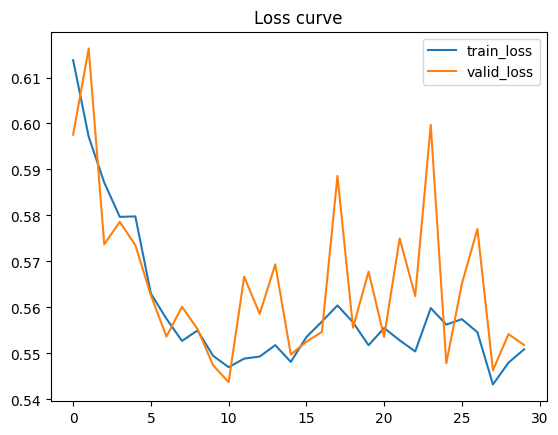

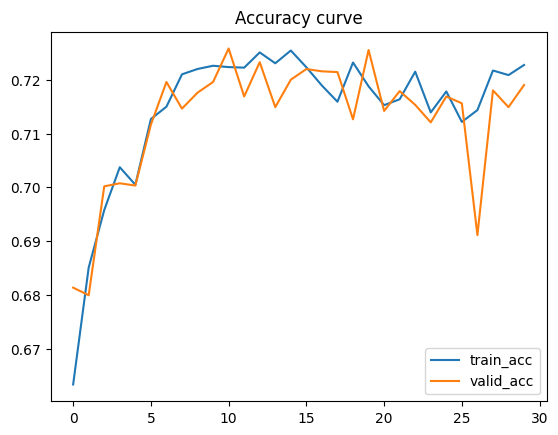

In [ ]:
plt.figure()
plt.plot(train_loss_list, label="train_loss")
plt.plot(valid_loss_list, label="valid_loss")
plt.legend()
plt.title(f"Loss curve")

plt.figure()
plt.plot(train_acc_list, label="train_acc")
plt.plot(valid_acc_list, label="valid_acc")
plt.legend()
plt.title(f"Accuracy curve")

In [ ]:
model = CNN(dyn_channels=5, stat_channels=32)
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/CognitiveAI/project/pre_cnn.pth"))


<All keys matched successfully>

In [ ]:
correct = 0
total = 0
y_true=[]
y_pred=[]
model = model.cuda()
for x_dynamic, x_static, y in test_loader:
            model.eval()
            if torch.cuda.is_available():
                x_dynamic = x_dynamic.cuda()
                x_static = x_static.cuda()
                y = y.cuda()
            y = y.float()
            with torch.no_grad():
                pred = model(x_dynamic, x_static)

                #pred_labels = (torch.sigmoid(pred) > 0.5).float()
                pred_labels = torch.argmax(pred, dim=-1)
                #print(pred_labels.shape)
                correct += (pred_labels == y).float().sum().item()
                total += y.shape[0]
                y_true.append(y.reshape(-1).cpu())
                y_pred.append(pred_labels.reshape(-1).cpu())
print(correct/total)

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


0.7098470363288719


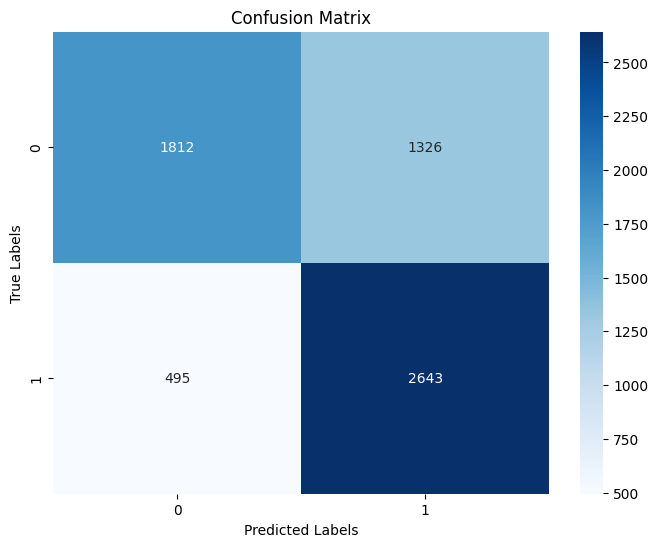

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
import seaborn as sns
y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)
CM = confusion_matrix(y_true, y_pred)
#auc_score = roc_auc_score(y_true, y_prob_list, multi_class='ovr')
plt.figure(figsize=(8, 6))
sns.heatmap(CM, annot=True, fmt="d", cmap='Blues')#, xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
for name, param in model.named_parameters():
    print(f"{name} has values: \n{param.data}")

conv1.weight has values: 
tensor([[[-4.8228, -3.8207, -0.2530, -4.2200],
         [ 3.8764,  4.7956,  2.5456, -3.9554],
         [-3.4054,  0.3887,  1.7390,  1.4055],
         [ 4.3852,  4.3070,  4.5597, -4.4087],
         [ 2.3435, -2.9521, -0.2153,  0.6045]],

        [[-3.2280,  3.8827,  3.7044,  4.4499],
         [-4.4664, -4.5074, -4.2220, -3.7589],
         [-4.6378, -3.9934, -4.0545, -4.0425],
         [-3.9063, -4.0234, -4.1722, -3.7133],
         [-4.0922, -4.1677, -4.6150, -4.4265]],

        [[ 0.0665, -4.3634, -3.8991, -2.7495],
         [ 4.2527,  1.2814, -1.6538, -4.5212],
         [-0.5275,  4.0935,  1.7521, -3.6942],
         [ 0.4796, -4.9455, -4.9144, -4.4651],
         [ 4.0545, -0.2479, -0.6982,  3.8483]],

        [[-2.9487, -4.2017, -4.8505, -4.0473],
         [ 0.1715, -0.0202,  4.2147,  4.1264],
         [-0.0490,  2.2388, -0.2243,  1.3728],
         [-0.6761, -0.2462,  3.8463,  0.3140],
         [-4.3655, -4.4881, -4.3937, -3.6718]],

        [[-3.7288, -3.1891